### IMPORT

In [26]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Reshape, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score
from keras.models import load_model

### DATA

train/test/val = 70/15/15

In [27]:
train_data_path = '../Dataset/train'
test_data_path = '../Dataset/test'
val_data_path = '../Dataset/val'

labels = ['Cam thao', 'Cay bac ha', 'Cay luu ly', 'Cay mac co', 'Cay ma de', 'Co thom', 'Dinh huong', 'Dong trung ha thao', 'Hat de ngua', 'Hoa dau biec', 'Ich mau', 'Ngai cuu', 'Nha dam', 'Toi', 'Trinh nu hoang cung', 'Y di']

### EXTRACT (trích xuất đặc trưng) 

- Feature extraction với EfficientNet B0 pretrained trên ImageNet:  là một kỹ thuật để trích xuất các đặc trưng (features) từ các ảnh sử dụng mô hình học sâu EfficientNet B0 được huấn luyện trước trên tập dữ liệu ImageNet.

> Giải thích code
- Tham số include_top=False --> không muốn sử dụng tầng fully-connected cuối cùng của mô hình, mà chỉ lấy ra các đặc trưng (features) trung gian.
- Tham số weights="imagenet" --> sử dụng trọng số (weights) được training trước trên tập dữ liệu ImageNet.
> File extracted.npy chứa các đặc trưng (features) được trích xuất từ các ảnh trong tập dữ liệu sử dụng mô hình EfficientNetB0 được training trên tập ImageNet.

In [28]:
#create model
model = EfficientNetB0(include_top=False, weights="imagenet")

# Extract data
def extractFeature (path):
  for label in labels:
    extract_feature= []
    base_path = os.path.join(path, label, '*')
    files = glob.glob(base_path) #glob.glob() --> lấy ra danh sách các file ảnh tương ứng với base_path
    for file in files:
      img = image.load_img(file, target_size=(224, 224)) #resize
      x = image.img_to_array(img) #chuyển ảnh thành numpy array
      x = np.expand_dims(x, axis=0) #thêm một chiều (axis=0) vào numpy array để tạo batch size bằng 1 --> tạo ra một batch chứa chỉ một ảnh duy nhất
      x = preprocess_input(x)

      extract_feature.append(model.predict(x)) #tiền xử lý ảnh đầu vào theo cách mà các mô hình EfficientNetB0 được train

    extract_feature = np.concatenate(extract_feature, axis=0) #nối danh sách các numpy array --> 1 numpy array
    path_save = os.path.join(path, label, 'extracted.npy')
    np.save(path_save, extract_feature)
    print('----- saved in ', label)

In [ ]:
extractFeature(train_data_path)
extractFeature(test_data_path)
extractFeature(val_data_path)

In [29]:
def loadFeature(path):
  feature = []
  target = []
  for label in labels:
    one_hots = tf.one_hot(labels.index(label), len(labels)).numpy() #.numpy() --> chuyển từ TensorFlow sang numpy array

    base_path = os.path.join(path, label, 'extracted.npy')
    feature_load = np.load(base_path) # đọc các đặc trưng và lưu vào feature_load
    feature.append(feature_load)
 
    one_hots = np.tile(one_hots, (len(feature_load), 1)) # nhân bản one_hots thành số hàng bằng với số lượng đặc trưng đọc được --> phù hợp kích thước
    target.append(one_hots)

  feature = np.concatenate(feature, axis= 0) #axis=0 -> bạn kết hợp các mảng theo chiều dọc --> một mảng numpy duy nhất, có số hàng bằng với tổng số đặc trưng
  target = np.concatenate(target, axis= 0)
  return feature, target

In [30]:
X_train, y_train = loadFeature(train_data_path)
X_val, y_val = loadFeature(val_data_path)
X_test, y_test = loadFeature(test_data_path)

In [31]:
X_train.shape


(3908, 7, 7, 1280)

> giải thích shape:
(983, 7, 7, 1280)
- 983 ảnh đầu vào
- 7x7 kích thước feature map
- 1280 --> mỗi vị trí (7x7) trong feature map chứa 1280 đặc trưng

### CREATE MODEL

> Giải thích code
- Vai trò của lớp GlobalAveragePooling2D: 
    + giảm kích thước không gian của đầu vào (giảm từ (7x7x1280 = 1x62720 (vecto 1D))) --> giảm số lượng tham số và số lượng tính toán trong mạng neural network --> cải thiện hiệu suất tính toán
    + trích xuất các đặc trưng quan trọng --> giúp mô hình học được các đặc trưng cao cấp hơn
    + tăng tính chất không nhạy cảm với vị trí (làm giảm sự phụ thuộc của mô hình vào vị trí cụ thể của các đặc trưng trong đầu vào) --> giúp mô hình có khả năng khái quát hóa tốt hơn
- Vai trò của kĩ thuật regularization Dropout: Ngăn chặn hiện tượng overfitting (quá khớp) trong quá trình huấn luyện
    + giải thích: Dropout ngẫu nhiên "tắt" một số nơ-ron trong quá trình đào tạo, buộc mô hình phải học các tính năng một cách tổng quát hơn, thay vì chỉ dựa vào một số nơ-ron quan trọng --> Điều này giúp mô hình trở nên ít nhạy cảm hơn với các nơ-ron riêng lẻ, tăng khả năng khái quát hóa.
- Vai trò của lớp Dense:
    + Có 16 nơron (16 labels), tạo ra 16 giá trị đầu ra
    + active function: softmax 
        + sử dụng ở lớp đầu ra của các mô hình phân loại đa lớp (labels)
        + biến đổi các giá trị đầu ra thành một phân phối xác suất, với tổng các xác suất bằng 1
        + [0.1, 0.2, 0.3, 0.4] (ví dụ cho 4 labels) - xsuat dự đoán labels 1 là 0.1...

- Vai trò optimizer (trình tối ưu):
    + cấu hình và khởi tạo một trình tối ưu hóa (optimizer) sử dụng thuật toán Adam
    + siêu tham số learning_rate
    > Việc cấu hình trình tối ưu hóa và learning rate phù hợp là rất quan trọng để đảm bảo mô hình được huấn luyện một cách hiệu quả. Nếu learning rate quá lớn, mô hình có thể không hội tụ; nếu quá nhỏ, quá trình huấn luyện sẽ diễn ra chậm.
- Compile:
    + Loss Function: categorical_crossentropy --> một hàm mất mát phổ biến được sử dụng cho các bài toán phân loại đa lớp, trong đó mỗi mẫu dữ liệu có thể thuộc về một trong nhiều lớp
    + metrics: accuracy --> đánh giá tỷ lệ các dự đoán chính xác của mô hình

In [32]:
inputs = Input(shape= (7, 7, 1280))
x = GlobalAveragePooling2D(name="average_pooling")(inputs)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(16, activation="softmax", name="pred")(x)

model = tf.keras.Model(inputs, outputs, name="Recognition") 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "Recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 7, 1280)]      0         
                                                                 
 average_pooling (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 pred (Dense)                (None, 16)                20496     
                                                                 
Total params: 25,616
Trainable params: 23,056
Non-train

### TRAIN MODEL

In [33]:
epochs = 50  #số lần mô hình được huấn luyện trên toàn bộ tập dữ liệu huấn luyện
batch_size = 32  #trong mỗi lần lặp, mô hình sẽ tiến hành tính toán và cập nhật trọng số dựa trên 32 (batch_size) mẫu dữ liệu được lấy ngẫu nhiên từ tập huấn luyện
hist = model.fit(X_train, y_train, epochs= epochs, batch_size= batch_size, shuffle= True, validation_data=(X_val, y_val)) #shuffle=True  --> Trước mỗi epoch (một lượt duyệt qua toàn bộ tập huấn luyện), dữ liệu sẽ được xáo trộn ngẫu nhiên
# số batch = tổng dữ liệu / batch_size

Epoch 1/50
123/123 [==============================] - 2s 7ms/step - loss: 3.5145 - accuracy: 0.0811 - val_loss: 2.8730 - val_accuracy: 0.0625
Epoch 2/50
123/123 [==============================] - 1s 5ms/step - loss: 3.2473 - accuracy: 0.1052 - val_loss: 2.8034 - val_accuracy: 0.1042
Epoch 3/50
123/123 [==============================] - 1s 5ms/step - loss: 3.0081 - accuracy: 0.1412 - val_loss: 2.6835 - val_accuracy: 0.1615
Epoch 4/50
123/123 [==============================] - 1s 5ms/step - loss: 2.7712 - accuracy: 0.1883 - val_loss: 2.5212 - val_accuracy: 0.2188
Epoch 5/50
123/123 [==============================] - 1s 5ms/step - loss: 2.5646 - accuracy: 0.2380 - val_loss: 2.3396 - val_accuracy: 0.2865
Epoch 6/50
123/123 [==============================] - 1s 5ms/step - loss: 2.3608 - accuracy: 0.2835 - val_loss: 2.1641 - val_accuracy: 0.3438
Epoch 7/50
123/123 [==============================] - 1s 5ms/step - loss: 2.2004 - accuracy: 0.3324 - val_loss: 1.9988 - val_accuracy: 0.3958
Epoch 

### DRAW PLOT

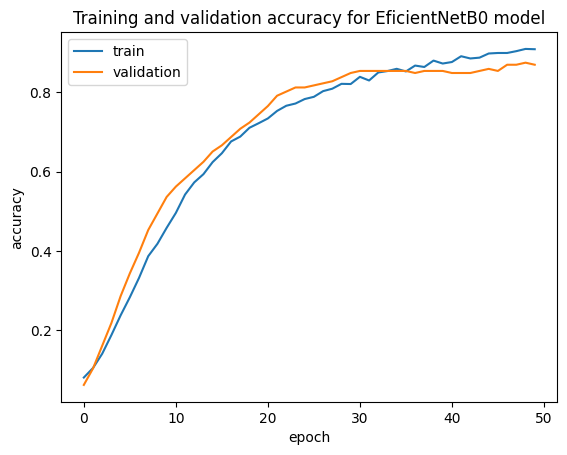

In [34]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Training and validation accuracy for EficientNetB0 model")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_hist(hist)

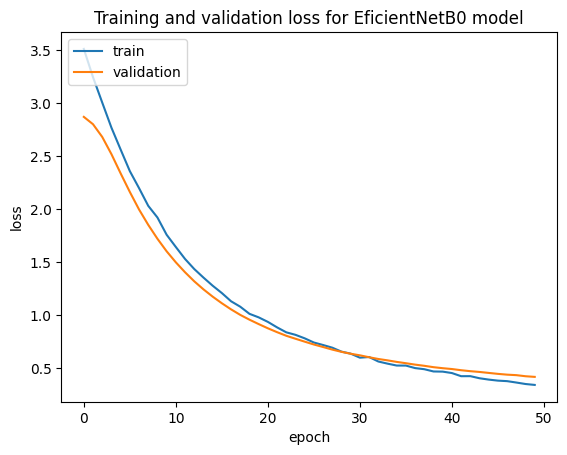

In [35]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training and validation loss for EficientNetB0 model")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
plot_hist(hist)

### SAVE MODEL

In [36]:
model_path = './pre-train.h5'
model.save(model_path)

### TEST MODEL

>giải thích code:
- np.array(y_pred).shape[1] lấy số lượng lớp (class) trong bài toán phân loại
- np.argmax(y_pred, axis=1) tìm chỉ số của lớp có xác suất dự đoán cao nhất cho mỗi mẫu dữ liệu
    + Ví dụ, đối với một bài toán phân loại 3 lớp, y_pred có thể có dạng [[0.2, 0.5, 0.3], [0.6, 0.1, 0.3], ...], trong đó mỗi hàng tương ứng với xác suất dự đoán cho 3 lớp.
np.argmax(y_pred, axis=1) sẽ tìm chỉ số của lớp có xác suất dự đoán cao nhất cho mỗi mẫu dữ liệu.

In [20]:
# img_path= '../Dataset/test/Cam thao/istockphoto-1407004454-612x612.jpg'
# model = load_model('../pre-train.h5')

In [37]:
acc_score = model.evaluate(X_train, y_train) #we are starting to test the model here
print('\n', 'train accuracy:', acc_score[1])

123/123 [==============================] - 1s 4ms/step - loss: 0.2487 - accuracy: 0.9455

 train accuracy: 0.9454964399337769


In [38]:
acc_score = model.evaluate(X_val, y_val) #we are starting to test the model here
print('\n', 'val accuracy:', acc_score[1])

6/6 [==============================] - 0s 5ms/step - loss: 0.4183 - accuracy: 0.8698

 val accuracy: 0.8697916865348816


In [39]:
acc_score = model.evaluate(X_test, y_test) #we are starting to test the model here
print('\n', 'test accuracy:', acc_score[1])

6/6 [==============================] - 0s 3ms/step - loss: 0.4461 - accuracy: 0.8750

 test accuracy: 0.875


# PREDICT HERB

### 1. Image & Load model

In [41]:
img_path= '../Dataset/test/Cam thao/istockphoto-1407004454-612x612.jpg'
model_saved = load_model('./pre-train.h5')
efficientNet = EfficientNetB0(include_top=False, weights="imagenet")

### 2. Predict

1/1 [==============================] - 0s 52ms/step
model's prediction: Cam thao - Percentage: 87.70875930786133 %


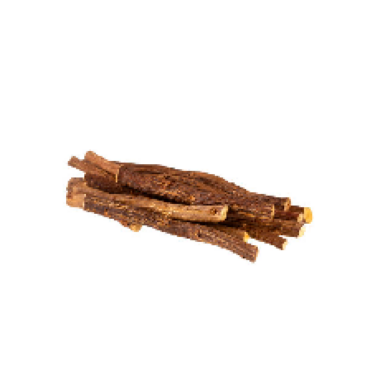

In [42]:
def prediction(image_path):
  img = image.load_img(image_path, target_size=(224, 224))
  img = image.img_to_array(img)

  feature = np.expand_dims(img, axis=0)
  feature = preprocess_input(feature)
  feature = efficientNet.predict(feature)
  output = model_saved.predict(feature)

  percent = output.max() * 100
  label_predict = labels[np.argmax(output)]

  print("model's prediction:",label_predict, "- Percentage:", percent, '%')
  plt.imshow(img.astype('uint8'))
  plt.axis('off')
  plt.show()

prediction(img_path)